In [1437]:
# Imports
import random
import sys
import numpy as np
import time as t
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import model
from keijzer_exogan import *

# initialize random seeds
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)


"""
Local variables
"""
workers = 0 # Number of workers for dataloader, 0 when to_vram is enabled
batch_size = 1 # using one image ofcourse
image_size = 32
nz = 100 # size of latent vector
n_iters = 50*10**3 # number of iterations to do for inpainting
torch.backends.cudnn.benchmark=True # Uses udnn auto-tuner to find the best algorithm to use for your hardware, speeds up training by almost 50%

lr = 1e-1
lamb = 1


lr_G = 2e-4
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
selected_gpus = [3] # Number of GPUs available. Use 0 for CPU mode.

In [1438]:
path = '/datb/16011015/ExoGAN_data/selection//' #notice how you dont put the last folder in here...
images = np.load(path+'last_chunks_25_percent_images.npy').astype('float32')

len(images)

1250000

In [1439]:
print('Batch size: ', batch_size)


# Number of training epochs

# Learning rate for optimizers
ngpu = len(selected_gpus)
print('Number of GPUs used: ', ngpu)


"""
Load data and prepare DataLoader
"""
shuffle = True

if shuffle:
    np.random.shuffle(images) # shuffles the images

images = images[:25] # 1200 should take ~ 1 hour
#images = images[:int(len(images)*0.005)]
print('Number of images: ', len(images))

Batch size:  1
Number of GPUs used:  1
Number of images:  25


In [1440]:
dataset = numpy_dataset(data=images, to_vram=True) # to_vram pins it to all GPU's
#dataset = numpy_dataset(data=images, to_vram=True, transform=transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # to_vram pins it to all GPU's

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=False)

"""
Load and setup models
"""
# Initialize cuda
device = torch.device("cuda:"+str(selected_gpus[0]) if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load models, set to evaluation mode since training is not needed (this also allows batchsize 1 to work with batchnorm2d layers)
netG = model.Generator(ngpu).eval().to(device)
netD = model.Discriminator(ngpu).eval().to(device)

# Apply weights
print('Loading weights...')
try:
    # Load saved weights
    netG.load_state_dict(torch.load('netG_state_dict0', map_location=device)) #net.module..load_... for parallel model , net.load_... for single gpu model
    netD.load_state_dict(torch.load('netD_state_dict0', map_location=device))
except:
    print('Could not load saved weights.')
    sys.exit()





"""
Define input training stuff (fancy this up)
"""
G = netG
D = netD
z = torch.randn(1, nz, 1, 1, requires_grad=True, device=device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    G = nn.DataParallel(G, device_ids=selected_gpus, output_device=device)
    D = nn.DataParallel(D, device_ids=selected_gpus, output_device=device)
    #z = nn.DataParallel(z, device_ids=selected_gpus, output_device=device)
    
criteria = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # should be sgd
optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, 0.999))

print('done')

Loading weights...
done


# Show generated images

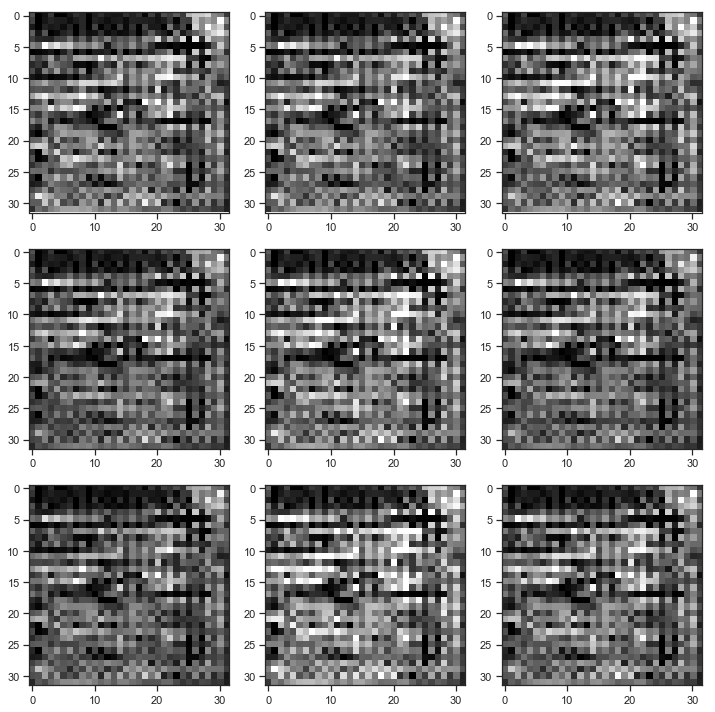

In [1441]:
from sklearn.preprocessing import MinMaxScaler

z_tests = [torch.randn(1, nz, 1, 1, device=device) for _ in range(9)]

plt.figure(figsize=(10,10))
for i in range(9):
    img = G(z_tests[i]).detach().cpu()[0, 0, :, :]
    plt.subplot(3,3,i+1)
    #scaler = MinMaxScaler((0, 1.2))
    #img = scaler.fit_transform(img)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1.2)
    #plt.imshow(img, cmap='gray')

plt.tight_layout()

In [1388]:
img.min(), img.max(), img.mean(), img.std()

(tensor(-0.0839), tensor(1.1918), tensor(0.4076), tensor(0.2821))

## Make sure Z is different for each image

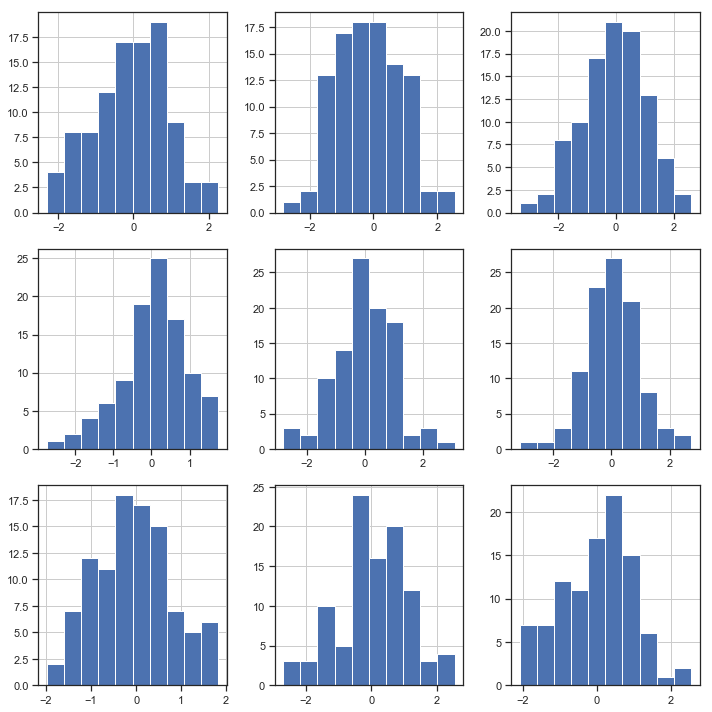

In [1389]:
plt.figure(figsize=(10,10))
for i,z_t in enumerate(z_tests):
    z_t = z_t.detach().cpu().numpy()
    
    plt.subplot(3,3,i+1)
    
    plt.hist(z_t.flatten())
    plt.grid()
    
    plt.tight_layout()
    #print(z_t[0].flatten())

## Show first 9 selected images

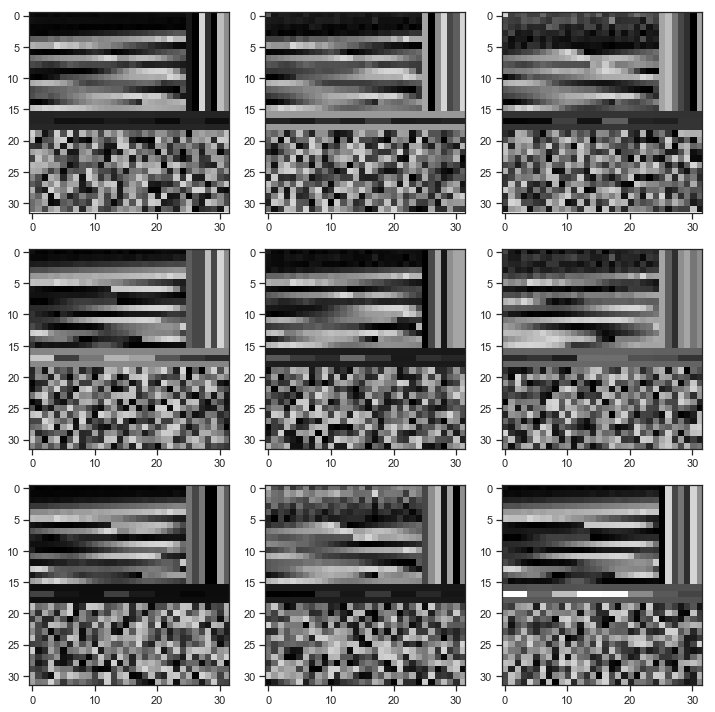

In [1390]:
plt.figure(figsize=(10,10))
for i in range(9):
    try:
        img = images[i]
        plt.subplot(3,3,i+1)
        plt.imshow(img[0, :, :], cmap='gray', vmin=0, vmax=1.2)
    except:
        pass

plt.tight_layout()

In [1391]:
img.min(), img.max(), img.mean(), img.std()

(0.0, 1.5223442, 0.46280527, 0.32197806)

# Visualizing the weights for debugging purposes

Layer: 0 	 n_weights: 512 	 std: 0.0370 	 mean: -0.0004
Layer: 1 	 n_weights: 16384 	 std: 0.3511 	 mean: -0.0132
Layer: 2 	 n_weights: 32768 	 std: 0.3937 	 mean: -0.0028
Layer: 3 	 n_weights: 131072 	 std: 0.4204 	 mean: 0.0136
Layer: 4 	 n_weights: 524288 	 std: 0.1916 	 mean: 0.0130
Layer: 5 	 n_weights: 256 	 std: 0.0099 	 mean: -0.0009


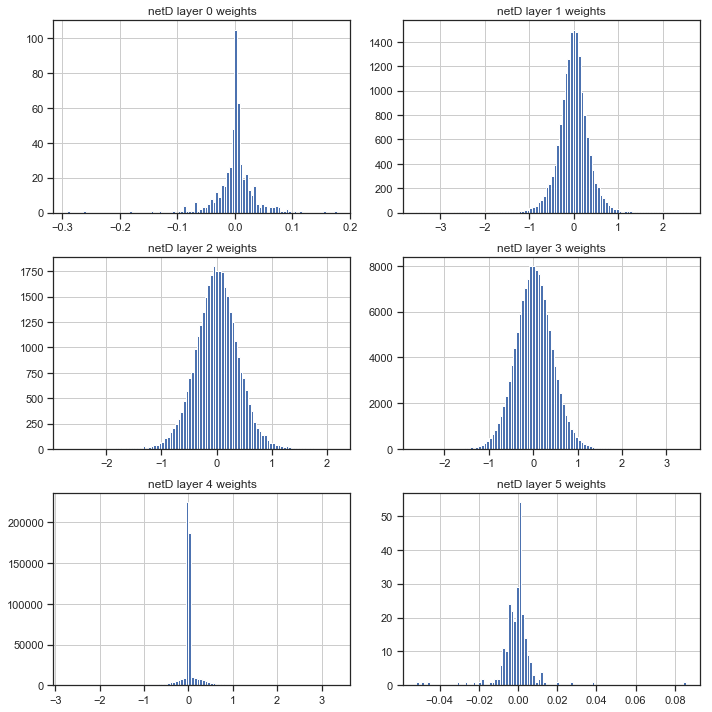

In [1392]:
weights = [param.data.cpu().numpy().flatten() for param in netD.parameters()]

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netD layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

Layer: 0 	 n_weights: 409600 	 std: 0.0416 	 mean: -0.0001
Layer: 1 	 n_weights: 524288 	 std: 0.0882 	 mean: -0.0048
Layer: 2 	 n_weights: 131072 	 std: 0.1122 	 mean: 0.0024
Layer: 3 	 n_weights: 32768 	 std: 0.0936 	 mean: -0.0083
Layer: 4 	 n_weights: 16384 	 std: 0.0997 	 mean: -0.0022
Layer: 5 	 n_weights: 512 	 std: 0.0259 	 mean: 0.0061


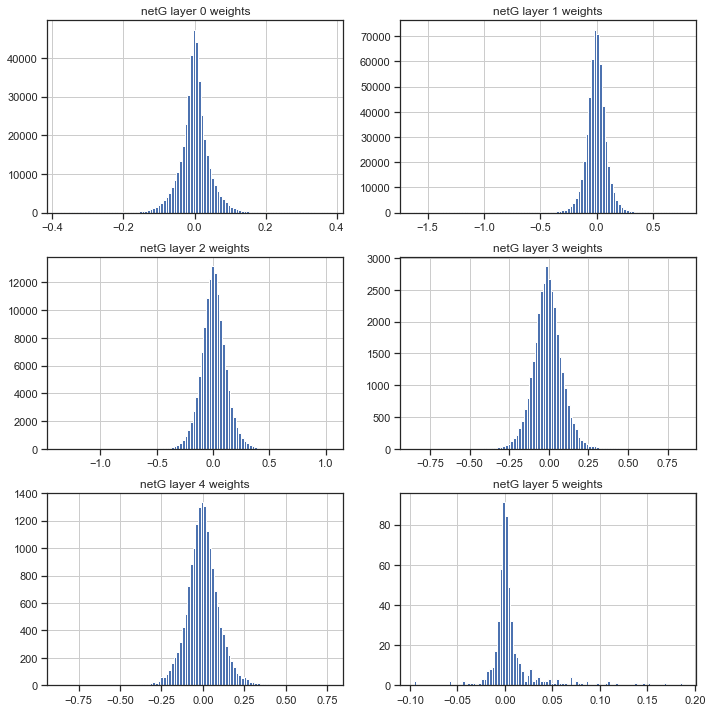

In [1393]:
weights = [param.data.cpu().numpy().flatten() for param in netG.parameters()] # where param.data are the weights of the i-th layer

plt.figure(figsize=(10,10))
for i,layer_weights in enumerate(weights):
    print('Layer: %s \t n_weights: %s \t std: %.4f \t mean: %.4f' % (i, len(layer_weights), layer_weights.std(), layer_weights.mean()))
    plt.subplot(3,2,i+1)
    plt.title('netG layer %s weights' % i)
    plt.hist(layer_weights, bins=100)
    plt.grid()
    plt.tight_layout()

# Inpainting
The corrupted image $y$ is mapped to the closest $z$ in the latent representation space, this mapping is denoted as $\hat{z}$.
    
$\hat{z} = \operatorname{arg\,min}_z \{ \mathcal{L}_c(z |y, M) + \mathcal{L}_p (z) \}$

where

$\mathcal{L}_c(z |y, M) = || M \bigodot G(z) - M \bigodot y||_1 = || M \bigodot (G(z)-y) ||_1 $

with $\mathcal{L}_c$ being contextual loss and $M$ being a binary mask with the same size as $y$,

$\mathcal{L}_p (z) = \lambda \operatorname{log}(1-D(G(z)))$

with $\mathcal{L}_p$ being perceptual loss and $D$ being the discriminator.
  
Once $G(\hat{z})$ is generated, the final solution $\hat{x}$ is calculated as

$\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$  

(substitute $x_i = y_i$ for $M_i = 1$).

-----

$|| ... ||$ is done by `torch.norm()`.  
$... \bigodot ...$ is done by `torch.mul()`.  
-----
TODO: Implement $\hat{x} = \operatorname{arg\, min}_x ||\nabla x - \nabla G(\hat{z}) ||^2_2$    
Currently $\hat{x} = G(\hat{z}) \bigodot (1 -M)+y$

In [1394]:
ind = pd.read_csv('wavelengths_and_indices.csv')  # where x is the wavelength

ind[(ind.x > 10) & (ind.x <= 14)]

,Unnamed: 0,x
129,129,13.900046
130,130,13.762421
131,131,13.626160
132,132,13.491247
133,133,13.357671
134,134,13.225416
135,135,13.094472
136,136,12.964823
137,137,12.836459
138,138,12.709365


In [1395]:
def create_mask():
    
    mask = np.full([1,1,32,32], 1) # init array with 0.5's
    mask = torch.from_numpy(mask).to(device)
    
    #mask = torch.ones([1, 1, 32, 32]).to(device) # create mask with 1's in the shape of image
    
    #print("mask.shape", mask.shape)

    # use a random 'easy' mask
    mask[:, :, :16, 25:] = 0
    
    # The noise doesn't matter for conceptual loss
    mask[:, :, 19:, :] = 0
    
    """Weighted mask"""
    
    # Normalization factors
    mask[:, :, 16:19, :] = 2
    
    mask = mask.float() # make sure dtype is float, torch was complaining during inpainting that this is a double
    
    return mask

## Visualize the mask

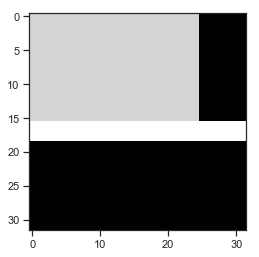

In [1396]:
m = create_mask().cpu()[0, 0, :, :]
plt.imshow(m, cmap='gray', vmin=0, vmax=1.2)

In [1397]:
t = m.cpu().numpy().flatten()

for i in range(len(t)):
    if np.isnan(t[i]):
        print('nan')

In [1398]:
# Lists to keep track of progress
real_images = []
masked_images= []
inpainted_images = []
final_inpainted_images = [] # last inpainted image for each input image
n_iteration = []

In [1399]:
MSELoss = nn.MSELoss()
L1Loss = nn.L1Loss() # MAE
SmoothL1Loss = nn.SmoothL1Loss()

"""
Inpainting
"""
for i, data in enumerate(dataloader, 0): # batches per epoch
    real_cpu = data.to(device)
    b_size = real_cpu.size(0) # this is one ofc, it's one image we're trying to inpaint

    #print("data.shape: ", data.shape)
    image = data.to(device) # select the image (Channel, Height, Width), this is the original unmasked input image
    
    real_images.append(image)
    #print("image.shape: ", image.shape)

    """Mask the image"""
    mask = create_mask()

    masked_image = torch.mul(image, mask).to(device) #image bigodot mask
    masked_images.append(masked_image)
    #print('masked image shape', masked_image.shape)
    #plt.imshow(masked_image.detach().cpu()[0, 0, :, :], cmap='gray') # plot the masked image

    opt = optim.Adam([z], lr=lr)

    # what's v and m?
    v = torch.tensor(0, dtype=torch.float32, device=device)
    m = torch.tensor(0, dtype=torch.float32, device=device)


    """Start the inpainting process"""
    early_stopping_n_iters = 0
    early_stopping_min_loss = 999999 # set to random high number to initialize
    for iteration in range(n_iters):
        if z.grad is not None:
            z.grad.data.zero_()

        G.zero_grad()
        D.zero_grad()


        image_generated = G(z) # generated image G(z)
        image_generated_masked = torch.mul(image_generated, mask) # G(z) bigodot M
        image_generated_inpainted = torch.mul(image_generated, (1-mask))+masked_image
        
        if (iteration % 100 == 0):
            inpainted_images.append(image_generated_inpainted)

        #print("image_generated_inpainted.shape : ",image_generated_inpainted.shape)

        t = image_generated_inpainted.detach().cpu()[0, 0, :, :]

        # TODO: why does this already look real?
        #plt.imshow(t, cmap='gray') # plot the masked image 

        """Calculate losses"""
        #loss_context = torch.norm(image_generated_masked-masked_image, p=1) #what's p=1?
        loss_context = MSELoss(image_generated_masked,masked_image)*1000
        #loss_context = L1Loss(image_generated_masked, masked_image)*10
        #loss_context = SmoothL1Loss(image_generated_masked, masked_image)*10
        
        discriminator_output = netD(image_generated_inpainted)
        #print("Discriminator output: ", discriminator_output)

        labels = torch.full((b_size,), 1, device=device)
        loss_perceptual = torch.log(1-discriminator_output)
        
        #print(loss_perceptual.data.cpu().numpy().flatten()[0])

        total_loss = loss_context + lamb*loss_perceptual
        #total_loss = loss_context + 10*discriminator_output
        
        # grab the values from losses for printing
        loss_perceptual = loss_perceptual.data.cpu().numpy().flatten()[0]
        #loss_perceptual = 0
        loss_context = loss_context.data.cpu().numpy().flatten()[0]



        total_loss.backward()
        opt.step()
        
        total_loss = total_loss.data.cpu().numpy().flatten()[0]
        
        """Early stopping""" # TODO: 
        if iteration > 0:
            delta_loss = early_stopping_min_loss - total_loss
            delta_iters = iteration - iter1
            
            if (delta_loss < 0.1) or (total_loss > early_stopping_min_loss):
                early_stopping_n_iters += 1
            else:
                #print('set to zero')
                early_stopping_n_iters = 0
            
            if early_stopping_n_iters > 500:
                n_iteration.append(iteration)
                break
            
        loss1 = total_loss
        iter1 = iteration
        
        if total_loss < early_stopping_min_loss:
            early_stopping_min_loss = total_loss
            best_inpained_image = image_generated_inpainted.detach().cpu()
            early_stopping_n_iters = 0
            #print('min loss: ', early_stopping_min_loss)
        
        if (iteration % 50 == 0):
            print("\r image [{}/{}] iteration : {:4} , context_loss: {:.3f}, perceptual_loss: {:3f}, total_loss: {:3f}, min L: {:3f}, {:1f}, D(G(z)): {:3f}".format(i+1, 
            len(images), iteration,loss_context,loss_perceptual, total_loss,early_stopping_min_loss, early_stopping_n_iters, discriminator_output.data.cpu().numpy().flatten()[0]),end="")

    final_inpainted_images.append(best_inpained_image.detach().cpu())

 image [25/25] iteration : 4650 , context_loss: 0.528, perceptual_loss: -2.449388, total_loss: -1.921250, min L: -2.153360, 491.000000, D(G(z)): 0.913654

In [1400]:
len(real_images)

25

# Show results

In [1401]:
real = real_images[0].detach().cpu()[0, 0, :, :]
real_masked = masked_images[0].detach().cpu()[0, 0, :, :]

#first_generated =inpainted_images[1].detach().cpu()[0, 0, :, :]
last_generated = inpainted_images[-1].detach().cpu()[0, 0, :, :]

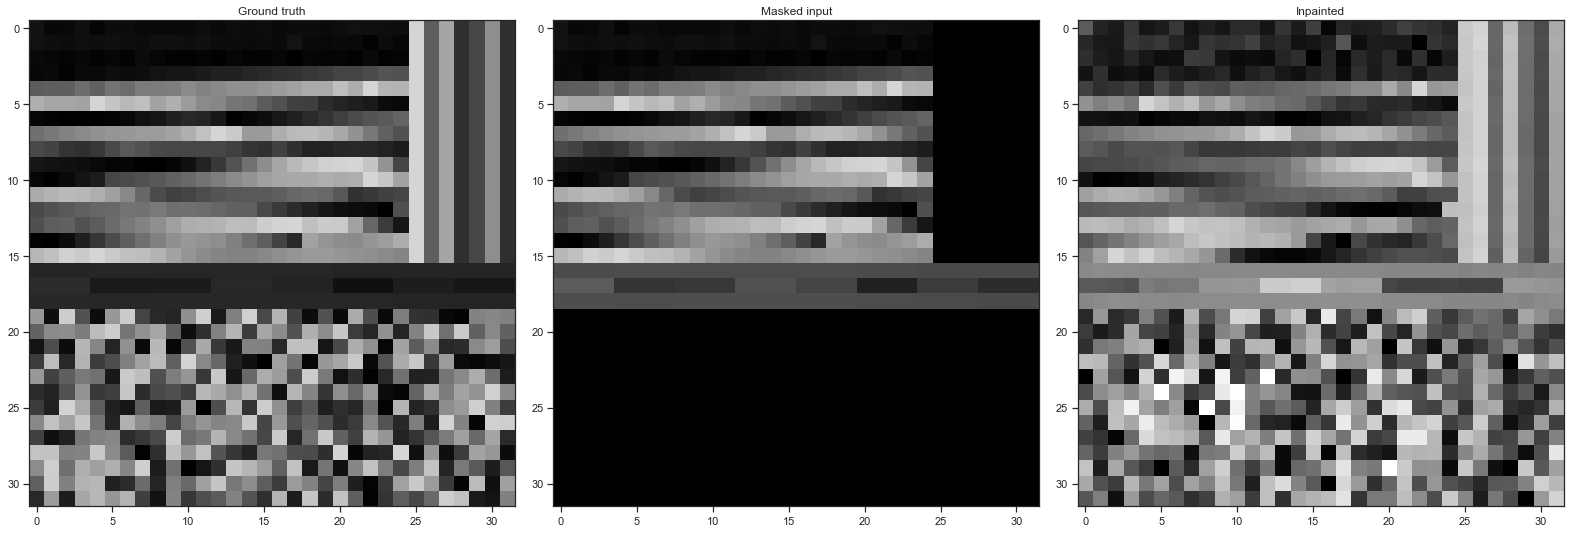

In [1402]:
plt.figure(figsize=(22,10))

plt.subplot(1,3,1)
plt.imshow(real, cmap='gray', vmin=0, vmax=1.2)
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.imshow(real_masked, cmap='gray', vmin=0, vmax=1.2)
plt.title('Masked input')

plt.subplot(1,3,3)
plt.imshow(last_generated, cmap='gray', vmin=0, vmax=1.2)
plt.title('Inpainted')

plt.tight_layout()

#plt.savefig('plots/inpainting.png', dpi=1300)

mean: -0.0646 
 std: 0.2254 
 min: -0.7814 
 max: 0.5939


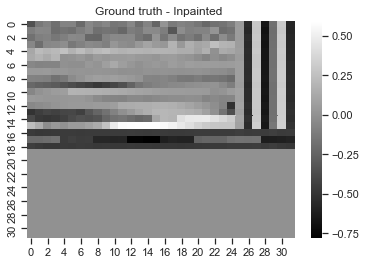

In [1403]:
difference = real - last_generated
difference[19:, :] = 0 # remove the noise, it doesn't matter

sns.heatmap(difference, cmap='gray')
plt.title('Ground truth - Inpainted ')

difference  = difference.cpu().detach().numpy().flatten()

mean, sigma, min_, max_ = difference.mean().item(), difference.std(), difference.min(), difference.max()
print('mean: %.4f \n std: %.4f \n min: %.4f \n max: %.4f' % (mean, sigma, min_, max_))

# Decoding ASPA
Need to clean this up. Using dicts like this is not clean.

In [1404]:
aspa_inpainted = last_generated.numpy()
aspa_real = real.numpy()

aspa_inpainted.shape

(32, 32)

In [1405]:
# Initialize ExoGAN params with zero's
inpainted_params = {
    'planet_mass': 0,
    'temp_profile': 0,
    'ch4_mixratio': 0,
    'planet_radius': 0,
    'h2o_mixratio': 0,
    'co2_mixratio': 0,
    'co_mixratio': 0
}

real_params = inpainted_params.copy()
params_errors = inpainted_params.copy()

## Inverse scale functions

In [1406]:
def inverse_scale_param(X_scaled, X_min, X_max):
    return (X_scaled * (X_max-X_min)) + X_min

def inverse_scale_params(params):
    """
    Inverse scales the params array. 
    Params must be in fixed order, same order as it is encoded with.
    """
    params = params.copy()
    min_values = [1.518400e+27, 
                  1.000000e+03, 
                  -1.842068e+01, 
                  5.592880e+07, 
                  -1.842068e+01, 
                  -1.842068e+01, 
                  -1.842068e+01]
    
    max_values = [3.796000e+27, 
                  2.000000e+03, 
                  -2.302585e+00, 
                  1.048665e+08, 
                  -2.302585e+00, 
                  -2.302585e+00,
                  -2.302585e+00]

    params_inverse_scaled = []
    for i in range(len(params)):
        param = params[i]
        min_= min_values[i]
        max_ = max_values[i]

        params_inverse_scaled.append(inverse_scale_param(param, min_, max_))
    
    return params_inverse_scaled

## Inpainted params

In [1407]:
inpainted_params_values = [aspa_inpainted[:16, 25+i:26+i] for i in range(len(inpainted_params))]
inpainted_params_mean  = [i.mean() for i in inpainted_params_values]

inpainted_params_mean

[0.9241188,
 0.9887502,
 0.48224056,
 0.88447773,
 0.5060325,
 0.34772474,
 0.77111244]

In [1408]:
y = (0.5876265 * (-2.306--1.842068e+01))+-1.842068e+01
y

-8.95126699298

In [1409]:
inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
inpainted_params_mean

[3.6231730172634126e+27,
 1988.7502193450928,
 -10.6478808786124,
 99213106.03085756,
 -10.264399664894642,
 -12.816019675543608,
 -5.9918164038944255]

### Convert mixtures from log back to regular scale

In [1410]:
for i,param in enumerate(inpainted_params):
    if 'mixratio' in param:
        inpainted_params[param] = 10**(inpainted_params_mean[i]) # convert log back to regular scale
    else:
        inpainted_params[param] = inpainted_params_mean[i]

In [1411]:
inpainted_params

{'planet_mass': 3.6231730172634126e+27,
 'temp_profile': 1988.7502193450928,
 'ch4_mixratio': 2.2496715771816377e-11,
 'planet_radius': 99213106.03085756,
 'h2o_mixratio': 5.4400179800303266e-11,
 'co2_mixratio': 1.5274968540159973e-13,
 'co_mixratio': 1.0190220841695218e-06}

## Real params
Ground truth params

In [1412]:
real_params_values = [aspa_real[:16, 25+i:26+i] for i in range(len(real_params))]
real_params_mean  = [i.mean() for i in real_params_values]
real_params_mean

[1.0, 0.44444445, 0.7777778, 0.22222222, 0.3333333, 0.6666666, 0.22222218]

In [1413]:
real_params_mean = inverse_scale_params(real_params_mean)
real_params_mean

[3.796e+27,
 1444.4444477558136,
 -5.884383675397039,
 66803844.52546984,
 -13.047981986904443,
 -7.6752839738088845,
 -14.838881804959627]

### Convert mixtures from log back to regular scale

In [1414]:
for i,param in enumerate(real_params):
    if 'mixratio' in param:
        real_params[param] = 10**(real_params_mean[i]) # convert log back to regular scale
    else:
        real_params[param] = real_params_mean[i]

In [1415]:
real_params

{'planet_mass': 3.796e+27,
 'temp_profile': 1444.4444477558136,
 'ch4_mixratio': 1.3050174672324571e-06,
 'planet_radius': 66803844.52546984,
 'h2o_mixratio': 8.954019030823769e-14,
 'co2_mixratio': 2.112107536315664e-08,
 'co_mixratio': 1.449166196458358e-15}

## Percentage error

% error = $\frac{y-\hat{y}}{\hat{y}} \cdot$ 100

In [1416]:
percentage_errors = []
for param in real_params:
    y_hat = real_params[param]
    y = inpainted_params[param]
    
    params_errors[param] = ((y - y_hat) / y_hat)*100

params_errors

{'planet_mass': -4.55287098884582,
 'temp_profile': 37.68270717748608,
 'ch4_mixratio': -99.99827613680762,
 'planet_radius': 48.51406642177797,
 'h2o_mixratio': 60655.04152161541,
 'co2_mixratio': -99.99927679020706,
 'co_mixratio': 70317820358.40755}

## Print results

In [1417]:
for param in inpainted_params:
    real = real_params[param]
    inpainted = inpainted_params[param]
    error = params_errors[param]
    
    print('%s \t Real value: %.5e \t inpainted value: %.5e \t perc. diff.: %.25f' % (param, real, inpainted, error))

planet_mass 	 Real value: 3.79600e+27 	 inpainted value: 3.62317e+27 	 perc. diff.: -4.5528709888458198662419818
temp_profile 	 Real value: 1.44444e+03 	 inpainted value: 1.98875e+03 	 perc. diff.: 37.6827071774860797859219019
ch4_mixratio 	 Real value: 1.30502e-06 	 inpainted value: 2.24967e-11 	 perc. diff.: -99.9982761368076182861841517
planet_radius 	 Real value: 6.68038e+07 	 inpainted value: 9.92131e+07 	 perc. diff.: 48.5140664217779686850917642
h2o_mixratio 	 Real value: 8.95402e-14 	 inpainted value: 5.44002e-11 	 perc. diff.: 60655.0415216154069639742374420
co2_mixratio 	 Real value: 2.11211e-08 	 inpainted value: 1.52750e-13 	 perc. diff.: -99.9992767902070625041233143
co_mixratio 	 Real value: 1.44917e-15 	 inpainted value: 1.01902e-06 	 perc. diff.: 70317820358.4075469970703125000000000


# Functionize this to output the MAPE of all inpainted images per metric 

In [1418]:
#real_images = []
#final_inpainted_images = []

reals = []
inpainteds = []
errors = []
for i in range(len(real_images)-1):
    aspa_real = real_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now
    aspa_inpainted = final_inpainted_images[i].detach().cpu()[0, 0, :, :].numpy() # size is 32,32 now

    """Decode inpainted aspa"""
    inpainted_params_values = [aspa_inpainted[:16, 25+j:26+j] for j in range(len(inpainted_params))]
    inpainted_params_mean  = [k.mean() for k in inpainted_params_values]
    inpainted_params_mean = inverse_scale_params(inpainted_params_mean)
    
    for a,param in enumerate(inpainted_params):
        if 'mixratio' in param:
            inpainted_params[param] = inpainted_params_mean[a] # convert log back to regular scale
        else:
            inpainted_params[param] = inpainted_params_mean[a]
    
    """Decode real aspa"""
    real_params_values = [aspa_real[:16, 25+b:26+b] for b in range(len(real_params))]
    real_params_mean  = [c.mean() for c in real_params_values]
    real_params_mean = inverse_scale_params(real_params_mean)
    
    for d,param in enumerate(real_params):
        if 'mixratio' in param:
            real_params[param] = real_params_mean[d] # convert log back to regular scale
        else:
            real_params[param] = real_params_mean[d]

    """Calculate percentage difference"""
    params_errors = dict.fromkeys(params_errors, 0) # copy dicts' keys, set all values to zero
    for param in real_params:
        y_hat = real_params[param]
        y = inpainted_params[param]
        
        params_errors[param] = ((y - y_hat) / y_hat)*100

    reals.append(real_params.copy()) # !!!!! for some reason dicts need to be copied, to be able to append to a list... otherwise the dicts inside the lists get update too
    inpainteds.append(inpainted_params.copy())
    errors.append(params_errors.copy())


# Create one large df from all the dicts

In [1419]:
reals[1]

{'planet_mass': 2.0245333371043206e+27,
 'temp_profile': 1777.7777910232544,
 'ch4_mixratio': -4.09348433769852,
 'planet_radius': 55928800.0,
 'h2o_mixratio': -4.09348433769852,
 'co2_mixratio': -14.838881804959627,
 'co_mixratio': -7.6752839738088845}

In [1420]:
dfs = []
for i in range(len(errors)):
    print(reals[i])
    df1 = pd.DataFrame(errors[i], index=[0])
    df1.columns = [i+'_error' for i in df1.columns]

    df2 = pd.DataFrame(reals[i], index=[0])
    df2.columns = [i+'_real' for i in df2.columns]

    df3 = pd.DataFrame(inpainteds[i], index=[0])
    df3.columns = [i+'_inpainted' for i in df3.columns]

    df = pd.concat([df1, df2, df3], axis=1)
    
    dfs.append(df)

df = pd.concat(dfs)

{'planet_mass': 3.796e+27, 'temp_profile': 1444.4444477558136, 'ch4_mixratio': -5.884383675397039, 'planet_radius': 66803844.52546984, 'h2o_mixratio': -13.047981986904443, 'co2_mixratio': -7.6752839738088845, 'co_mixratio': -14.838881804959627}
{'planet_mass': 2.0245333371043206e+27, 'temp_profile': 1777.7777910232544, 'ch4_mixratio': -4.09348433769852, 'planet_radius': 55928800.0, 'h2o_mixratio': -4.09348433769852, 'co2_mixratio': -14.838881804959627, 'co_mixratio': -7.6752839738088845}
{'planet_mass': 2.277600022625923e+27, 'temp_profile': 2000.0, 'ch4_mixratio': -16.62978126274731, 'planet_radius': 93991456.20375872, 'h2o_mixratio': -7.6752839738088845, 'co2_mixratio': -7.6752839738088845, 'co_mixratio': -18.420680743952346}
{'planet_mass': 2.783733393669128e+27, 'temp_profile': 1333.3333432674408, 'ch4_mixratio': -9.466183311507404, 'planet_radius': 55928800.0, 'h2o_mixratio': -18.420680743952346, 'co2_mixratio': -5.884383675397039, 'co_mixratio': -11.257082649205923}
{'planet_mass

# Errors of all images

In [1421]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,...,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,7.817287,12.186010,-2.072834,-0.578849,-15.253232,-1.585592,0.731861,2.499033e+27,1578.703712,-9.615425,...,-11.257083,-8.943837,-10.510875,2.576203e+27,1699.093999,-9.307766,7.907884e+07,-9.419824,-8.551415,-8.925190
std,33.087543,28.606559,15.970385,0.765835,18.047053,19.620266,77.842093,7.052485e+26,335.706796,5.305224,...,4.811288,5.500415,4.447300,7.412731e+26,233.293063,5.133788,1.685198e+07,4.316295,5.268294,4.781096
min,-54.773744,-26.545062,-37.661882,-2.369981,-62.752418,-26.508949,-83.574008,1.518400e+27,1000.000000,-18.420681,...,-18.420681,-18.420681,-18.420681,1.500581e+27,1051.641654,-18.386189,5.512309e+07,-15.878966,-18.247604,-17.827640
25%,-9.966203,-7.623366,-5.920030,-1.085763,-24.535587,-12.886858,-44.130249,2.024533e+27,1333.333343,-13.495707,...,-14.838882,-12.152532,-13.495707,1.989951e+27,1562.402993,-13.853929,6.405567e+07,-13.422236,-12.861735,-11.396931
50%,-1.450595,6.311206,-1.634973,-0.561758,-12.184379,-6.532288,-21.155900,2.530667e+27,1666.666687,-8.570734,...,-12.152532,-7.675284,-11.257083,2.480680e+27,1732.301652,-8.450415,8.000220e+07,-8.934318,-6.596691,-7.735791
75%,23.127897,17.712846,4.567580,-0.089525,-5.381984,3.592937,11.551938,3.289867e+27,1888.888896,-5.884384,...,-7.227559,-5.436659,-7.675284,3.005763e+27,1870.776251,-4.924586,9.359074e+07,-6.219210,-4.907901,-5.844727
max,87.463912,86.624098,28.001893,0.549469,13.426206,73.701870,282.019609,3.796000e+27,2000.000000,-2.302585,...,-2.302585,-2.302585,-2.302585,3.943432e+27,2008.376360,-2.610888,1.044115e+08,-1.605770,-1.900849,-2.437434


In [1422]:
df.describe()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,...,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,7.817287,12.186010,-2.072834,-0.578849,-15.253232,-1.585592,0.731861,2.499033e+27,1578.703712,-9.615425,...,-11.257083,-8.943837,-10.510875,2.576203e+27,1699.093999,-9.307766,7.907884e+07,-9.419824,-8.551415,-8.925190
std,33.087543,28.606559,15.970385,0.765835,18.047053,19.620266,77.842093,7.052485e+26,335.706796,5.305224,...,4.811288,5.500415,4.447300,7.412731e+26,233.293063,5.133788,1.685198e+07,4.316295,5.268294,4.781096
min,-54.773744,-26.545062,-37.661882,-2.369981,-62.752418,-26.508949,-83.574008,1.518400e+27,1000.000000,-18.420681,...,-18.420681,-18.420681,-18.420681,1.500581e+27,1051.641654,-18.386189,5.512309e+07,-15.878966,-18.247604,-17.827640
25%,-9.966203,-7.623366,-5.920030,-1.085763,-24.535587,-12.886858,-44.130249,2.024533e+27,1333.333343,-13.495707,...,-14.838882,-12.152532,-13.495707,1.989951e+27,1562.402993,-13.853929,6.405567e+07,-13.422236,-12.861735,-11.396931
50%,-1.450595,6.311206,-1.634973,-0.561758,-12.184379,-6.532288,-21.155900,2.530667e+27,1666.666687,-8.570734,...,-12.152532,-7.675284,-11.257083,2.480680e+27,1732.301652,-8.450415,8.000220e+07,-8.934318,-6.596691,-7.735791
75%,23.127897,17.712846,4.567580,-0.089525,-5.381984,3.592937,11.551938,3.289867e+27,1888.888896,-5.884384,...,-7.227559,-5.436659,-7.675284,3.005763e+27,1870.776251,-4.924586,9.359074e+07,-6.219210,-4.907901,-5.844727
max,87.463912,86.624098,28.001893,0.549469,13.426206,73.701870,282.019609,3.796000e+27,2000.000000,-2.302585,...,-2.302585,-2.302585,-2.302585,3.943432e+27,2008.376360,-2.610888,1.044115e+08,-1.605770,-1.900849,-2.437434


In [1423]:
params = [param for param in real_params.keys()]
param = params[2]
print(param)

ch4_mixratio


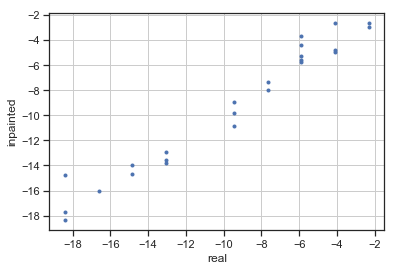

In [1424]:
x = df[param+'_real']
y = df[param+'_inpainted']

plt.plot(x, y, '.')
plt.xlabel('real')
plt.ylabel('inpainted')
plt.grid()

In [1425]:
x

0    -5.884384
0    -4.093484
0   -16.629781
0    -9.466183
0    -5.884384
0    -4.093484
0   -18.420681
0    -2.302585
0   -18.420681
0    -2.302585
0    -5.884384
0    -4.093484
0   -13.047982
0    -5.884384
0   -18.420681
0   -14.838882
0    -9.466183
0    -5.884384
0   -14.838882
0   -13.047982
0   -13.047982
0    -9.466183
0    -7.675284
0    -7.675284
Name: ch4_mixratio_real, dtype: float64

In [1426]:
y

0    -3.668214
0    -4.780472
0   -16.058733
0    -8.910690
0    -5.758286
0    -4.972624
0   -18.386189
0    -2.610888
0   -14.759171
0    -2.947352
0    -5.258752
0    -2.629560
0   -13.826127
0    -4.402594
0   -17.727117
0   -14.671643
0    -9.808597
0    -5.608064
0   -13.937335
0   -12.953911
0   -13.524988
0   -10.817439
0    -7.377488
0    -7.990140
Name: ch4_mixratio_inpainted, dtype: float64

(array([2., 1., 1., 0., 3., 8., 4., 2., 1., 2.]),
 array([-37.6618824 , -31.0955049 , -24.52912741, -17.96274991,
        -11.39637241,  -4.82999492,   1.73638258,   8.30276008,
         14.86913757,  21.43551507,  28.00189257]),
 <a list of 10 Patch objects>)

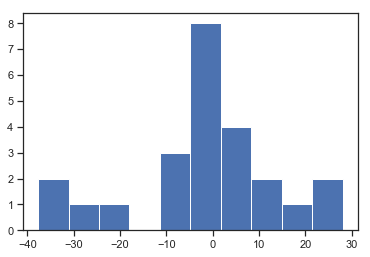

In [1427]:
plt.hist(df[param+'_error'])

saved


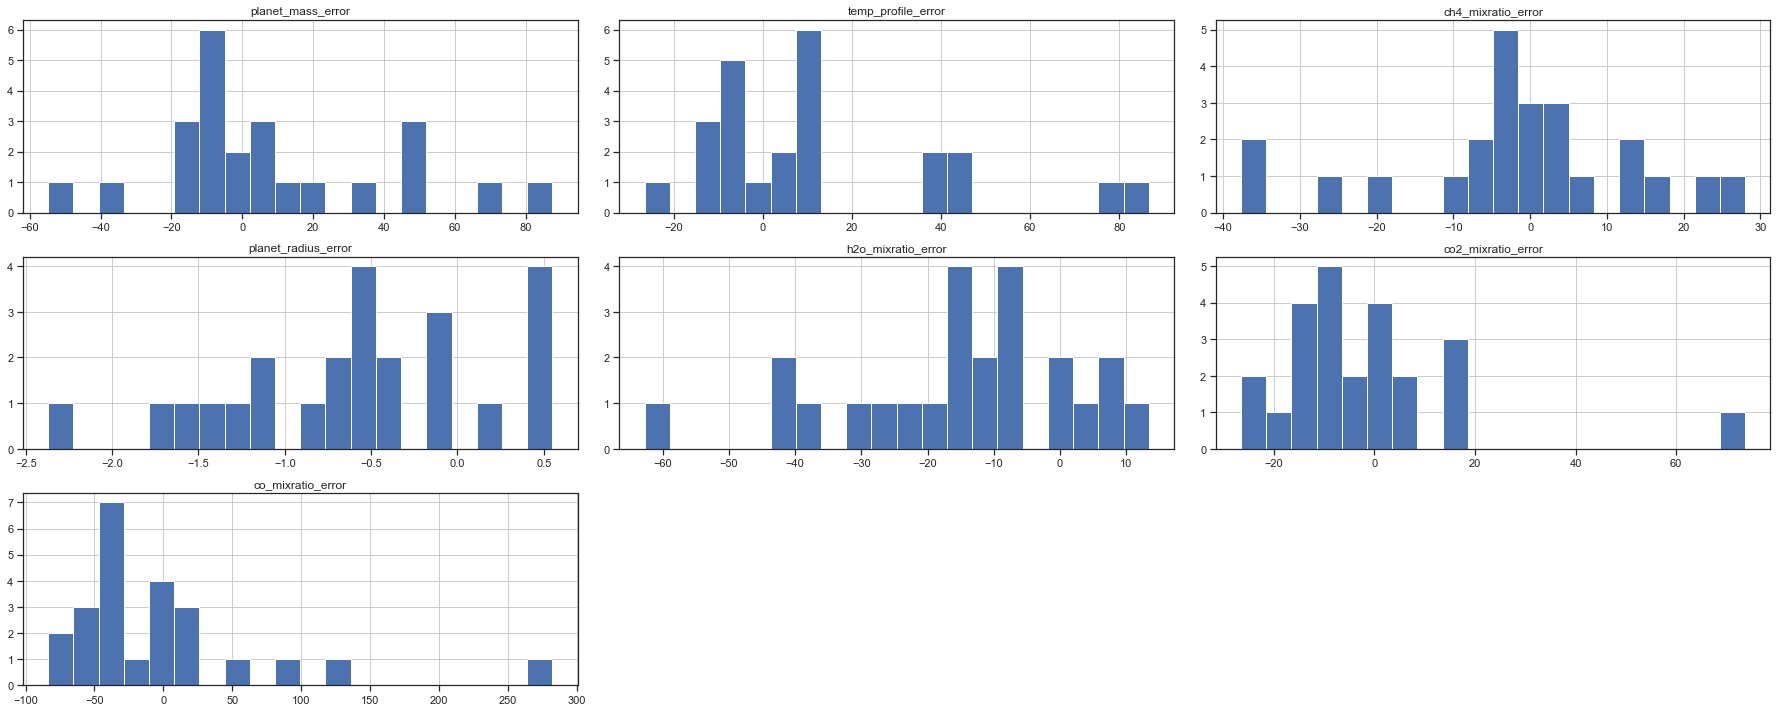

In [1428]:
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

plt.savefig('plots//Validation error hist of '+str(len(images))+' images.png', dpi=1200)
print('saved')

In [1429]:
df.to_csv('Validation error of '+str(len(images))+' images')

In [1430]:
df.head()

,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,ch4_mixratio_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,-37.798784,39.041440,-37.661882,-2.369981,-41.514396,-26.508949,-83.574008,3.796000e+27,1444.444448,-5.884384,...,-13.047982,-7.675284,-14.838882,2.361158e+27,2008.376360,-3.668214,6.522061e+07,-7.631191,-5.640647,-2.437434
0,45.163490,10.603315,16.782472,0.527721,0.461900,3.047135,-12.245606,2.024533e+27,1777.777791,-4.093484,...,-4.093484,-14.838882,-7.675284,2.938883e+27,1966.281176,-4.780472,5.622395e+07,-4.112392,-15.291042,-6.735399
0,-9.778155,-6.889945,-3.433890,-1.119703,-15.175041,-6.455166,-61.605926,2.277600e+27,2000.000000,-16.629781,...,-7.675284,-7.675284,-18.420681,2.054893e+27,1862.201095,-16.058733,9.293903e+07,-6.510556,-7.179832,-7.072450
0,-6.593031,8.117536,-5.868184,-1.440595,-24.256180,-15.534296,-50.463100,2.783733e+27,1333.333343,-9.466183,...,-18.420681,-5.884384,-11.257083,2.600201e+27,1441.567153,-8.910690,5.512309e+07,-13.952527,-4.970286,-5.576410
0,-7.702592,-8.414210,-2.142917,0.471197,-7.035376,-9.749282,-44.292296,2.024533e+27,1777.777791,-5.884384,...,-13.047982,-5.884384,-13.047982,1.868592e+27,1628.191829,-5.758286,8.350805e+07,-12.130007,-5.310699,-7.268731


In [1431]:
print('DONE')

DONE


In [1432]:
param = params[2]
df[[param+'_real', param+'_inpainted']]

,ch4_mixratio_real,ch4_mixratio_inpainted
0,-5.884384,-3.668214
0,-4.093484,-4.780472
0,-16.629781,-16.058733
0,-9.466183,-8.910690
0,-5.884384,-5.758286
0,-4.093484,-4.972624
0,-18.420681,-18.386189
0,-2.302585,-2.610888
0,-18.420681,-14.759171
0,-2.302585,-2.947352


In [1433]:
print('Done')

Done


In [1434]:
print('Done')

Done


In [1435]:
print('done')

done


(3939.68, 1534.845756941068)

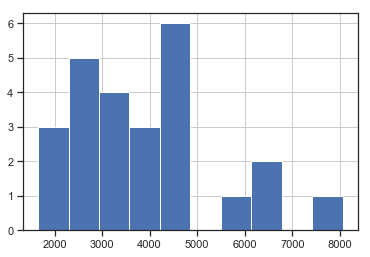

In [1436]:
its = np.array(n_iteration)
plt.hist(its)
plt.grid()

its.mean(), its.std()